In [1]:
import torch
import torch.optim as optim
import os

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import pickle
from model_definitions import GRU_Attention_submodel,Classnet
from utils import get_ade,get_fde,image_to_world
import datetime
print(datetime.datetime.now())
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.manual_seed(0)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from PIL import Image
im = Image.open("./NYGC_ref.jpg")

2021-10-29 16:48:24.821106


In [2]:
class fullmodel(nn.Module):
    def __init__(self,numrc,k,device,embed_dim,hidden_dim,dropout_rate,pred_len):
        super().__init__()
        self.classifier = Classnet(2,hidden_dim,RC_class_size=numrc)
        self.classifier.load_state_dict(torch.load("./subnets/NYGC_DDPTP_classnet.pth"))
        self.device = device
        self.classifier.to(device)
        self.classifier.eval()
        self.submodel = nn.ModuleList()
        for i in range(numrc):
            temp = GRU_Attention_submodel(embed_dim,hidden_dim,dropout_rate,pred_len)
            temp.load_state_dict(torch.load("./subnets/NYGC_DDPTP_attention_submodel_"+str(i)+".pth"))
            temp.to(device)
            temp.eval()
            self.submodel.append(temp)
        self.k = k
    def forward(self, x):
        classprob = self.classifier(x)
        #print(classprob)
        prob,indx =  torch.topk(classprob, self.k)
        #print(prob,indx)
        out = []
        #print(indx)
        for i in indx[0]:
            #print(i)
            out.append(self.submodel[i](x))
        out = torch.stack(out)[0]
        return out

In [3]:
numrc=4
k=1
embed_dim = 128
hidden_dim = 128
dropout_rate = 0.5
pred_len = 20

In [4]:
net = fullmodel(numrc,k,device,embed_dim,hidden_dim,dropout_rate,pred_len)
net.to(device)
net.eval()

/home/ai/anaconda3/envs/gpu6/lib/python3.9/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


fullmodel(
  (classifier): Classnet(
    (llstm): LSTM(2, 128, batch_first=True)
    (rlstm): LSTM(2, 128, batch_first=True)
    (lstm): LSTM(64, 128, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (conv1d0): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
    (conv1d1): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (pooling1d0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bnorm0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bnorm3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leftdense): Linear(in_features=2, out_features=2, bias=True)
    (rightdense): Linear(in_features=2, out_features=2, bias=True)
    (outputdense): Linear(in_features=128, out_features=4, b

In [5]:
with open('datas/NYGC_test_x.pickle', 'rb') as f:
    x = pickle.load(f)
with open('datas/NYGC_test_x.pickle', 'rb') as f:
    y = pickle.load(f)
tensor_x = torch.Tensor(x)
tensor_y = torch.tensor(y)
datas = TensorDataset(tensor_x,tensor_y)
allset = DataLoader(datas,batch_size=1,shuffle=False)

accuADE = []
accuFDE = []
for i, data in enumerate(allset, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    
    output1 = net(inputs)
    labelshape = labels.cpu().detach().numpy().shape
    outputshape = output1.cpu().detach().numpy().shape
    labels_world_coords = image_to_world(labels.cpu().detach().numpy().reshape((-1,2))).reshape(labelshape) 
    output_world_coords = image_to_world(output1.cpu().detach().numpy().reshape((-1,2))).reshape(outputshape)
    accuADE.append(get_ade(output_world_coords,labels_world_coords))
    accuFDE.append(get_fde(output_world_coords,labels_world_coords))
print('Final ADE: %.3f' %(np.mean(accuADE)/ 3.281))
print('Final FDE: %.3f' %(np.mean(accuFDE)/ 3.281))

torch.Size([956, 20, 2])


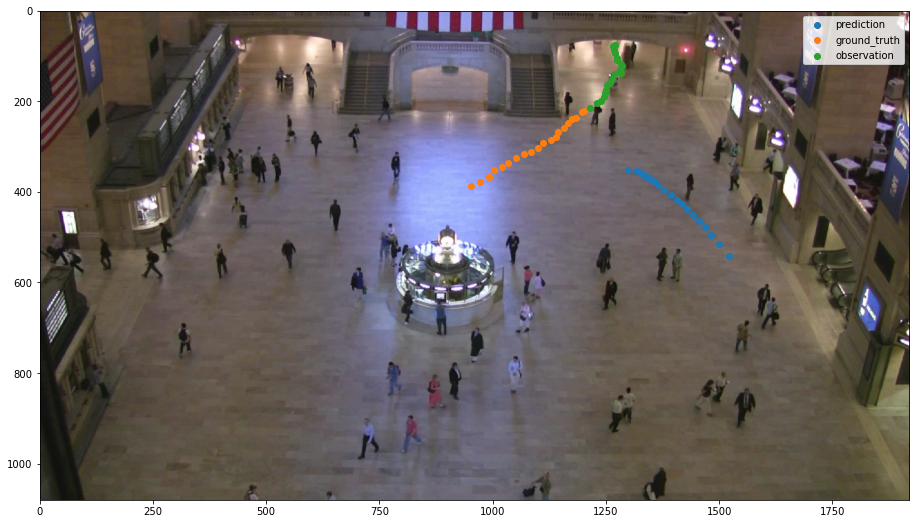

In [12]:
indx = 8
inputs, labels = datas[indx][0].to(device), datas[indx][1].to(device)
output1 = net(torch.unsqueeze(inputs,0))
inp = inputs.cpu().detach().numpy()
testest = output1.cpu().detach().numpy()[0]
testest2 = labels.cpu().detach().numpy()



import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(figsize=(16, 9))

plt.scatter(testest[:,0],testest[:,1])
plt.scatter(testest2[:,0],testest2[:,1])
plt.scatter(inp[:,0],inp[:,1])
plt.legend(['prediction',"ground_truth","observation"])
plt.axis([0, 1920, 0, 1080])
plt.gca().invert_yaxis()
plt.imshow(im,
           aspect='equal',
           origin="upper")